Comparatively evaluate the datasets

In [1]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import numpy as np

dir_pipeline = Path(".").resolve().parents[1]
dir_1 = dir_pipeline / "1_mechanistic_model"
sys.path.append(str(dir_1))

from reference_ruoff import (
    SPECIES_IDS,
    OBSERVED,
    OBSERVABLES_IDS,
    NOISE_PARAMETER_IDS,
    TRAINING_ENDPOINT,
    TEST_ENDPOINT,
    NOISE_PERCENTAGES,
    DATASET_SIZES,
)

problem_name = "ruoff_atp_consumption"
experiment_name = "2024_08_13_Ruoff_Grid"
metric = "negLL_obs_trainval"
metric_norm = metric + "_norm"
metric_test = "nmae_obs_test"

dir_output = Path(".").resolve() / "evaluation"
dir_output.mkdir(exist_ok=True)

In [2]:
# load the summary files from the previous grid, and the additinoal grid with sparsity 25
dir_opt_output_25 = dir_pipeline / "5_optimisation" / experiment_name
dir_opt_output_grid = dir_pipeline / "5_optimisation" / "2024_07_22_Ruoff_Grid"

In [3]:
def load_exp_summary(dir_exp_output: Path):
    summary = pd.read_csv(dir_exp_output / "experiment_summary.csv")
    # drop the runs that did not finish
    summary = summary.dropna(subset=NOISE_PARAMETER_IDS)
    return summary

columns = ["noise_level", "sparsity", metric, "nmse_obs_trainval", metric_test, "ude_nr", "λ_reg"]
summary_25 = load_exp_summary(dir_opt_output_25)[columns]
summary_grid = load_exp_summary(dir_opt_output_grid)[columns]

def data_settings():
    "Produces an iterator for the dataset specs."
    return product(NOISE_PERCENTAGES, DATASET_SIZES)

# make the ude_nrs unique
summary_25["ude_nr"] = summary_25["ude_nr"] + summary_grid["ude_nr"].max()

# combine
summary = pd.concat([summary_25, summary_grid]).rename(columns={"λ_reg": "regularisation"})

# add a column with the number of data points
sparsity_to_dps = {25: 8, 50: 16, 100: 31, 150: 46, 200: 61}
summary["ndp"] = summary["sparsity"].map(sparsity_to_dps)

# add a column indicating a successful fit: NMAE < 0.1
def nmae_to_success(x):
    if np.isnan(x):
        return 0
    elif x < 0.1:
        return 1
    else:
        return 0
summary["success"] = summary[metric_test].apply(nmae_to_success)

# calculate a normalised likelihood for comparison between data sets
summary[metric_norm] = summary[metric] / summary["ndp"]

In [4]:
summary["success"].value_counts()

success
0    196181
1      1435
Name: count, dtype: int64

In [5]:
best_ude_nrs = []
for (noise, n_datapoints) in data_settings():
    best = summary.query(
        "noise_level == @noise & (sparsity == @n_datapoints)"
    ).sort_values(by=metric).iloc[0]["ude_nr"]
    best_ude_nrs.append(best)

summary_of_best = summary.query("ude_nr in @best_ude_nrs")

In [6]:
summary_of_best.pivot(index="noise_level", columns="ndp", values=metric_norm)

ndp,8,16,31,46,61
noise_level,,,,,
5,-5.267735,-6.728974,-6.586771,-6.593138,-6.810727
10,-5.230322,-5.332432,-5.324657,-5.237583,-5.453950
20,-3.234063,-4.409851,-3.625363,-3.972589,-4.018667
35,-3.091074,-2.768174,-2.678600,-2.665725,-2.953496


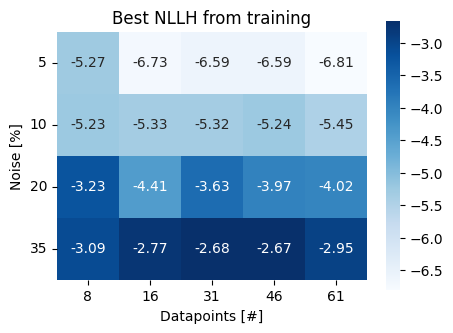

In [7]:
fig, ax = plt.subplots(figsize=(5, 3.5))
ax = sns.heatmap(
    summary_of_best.pivot(index="noise_level", columns="ndp", values=metric_norm),
    annot=True,
    fmt=".2f",
    cmap="Blues",
    square=True,
    ax=ax,
)
ax.set(xlabel="Datapoints [#]", ylabel="Noise [%]")
ax.set_title("Best NLLH from training")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
fp_output = dir_output / "heatmap_train.svg"
ax.figure.savefig(fp_output)

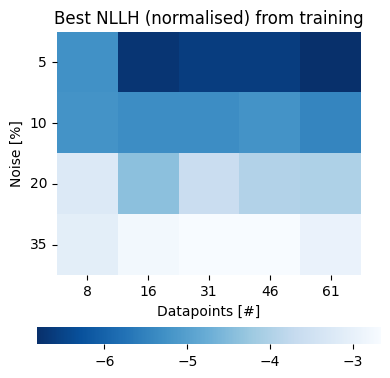

In [8]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.heatmap(
    summary_of_best.pivot(index="noise_level", columns="ndp", values=metric_norm),
    cmap="Blues_r",
    square=True,
    cbar_kws={"orientation": "horizontal"},
    ax=ax,
)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set(xlabel="Datapoints [#]", ylabel="Noise [%]")
ax.set_title("Best NLLH (normalised) from training")

fig.tight_layout()
fp_output = dir_output / "heatmap_train_simple.svg"
fig.savefig(fp_output)

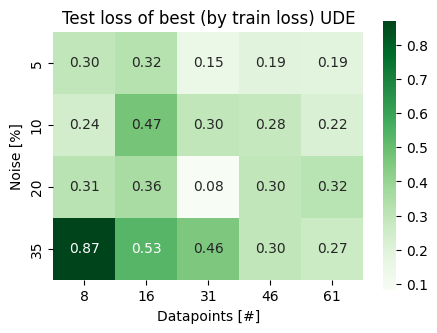

In [9]:
# heatmap test losses
fig, ax = plt.subplots(figsize=(5, 3.5))
sns.heatmap(
    summary_of_best.pivot(index="noise_level", columns="ndp", values=metric_test),
    annot=True,
    fmt=".2f",
    cmap="Greens",
    square=True,
    ax=ax,
)
ax.set(xlabel="Datapoints [#]", ylabel="Noise [%]")
ax.set_title("Test loss of best (by train loss) UDE")
fp_output = dir_output / "heatmap_test_by_train.svg"
ax.figure.savefig(fp_output)

NMSE on trainval observables

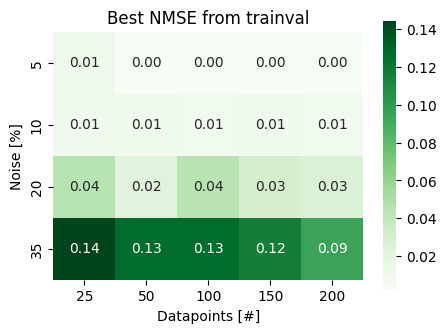

In [9]:
# heatmap test losses
fig, ax = plt.subplots(figsize=(5, 3.5))
sns.heatmap(
    summary_of_best.pivot(index="noise_level", columns="sparsity", values="nmse_obs_trainval"),
    annot=True,
    fmt=".2f",
    cmap="Greens",
    square=True,
    ax=ax,
)
ax.set(xlabel="Datapoints [#]", ylabel="Noise [%]")
ax.set_title("Best NMSE from trainval")
fp_output = dir_output / "heatmap_nmse_obs_trainval.svg"
ax.figure.savefig(fp_output)

#### Best test loss

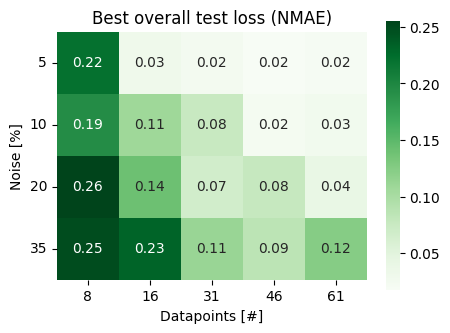

In [12]:
fig, ax = plt.subplots(figsize=(5, 3.5))
sns.heatmap(
    summary.groupby(by=["noise_level", "ndp"])["nmae_obs_test"].min().reset_index().pivot_table(
        values="nmae_obs_test", index="noise_level", columns="ndp"
    ),
    annot=True,
    fmt=".2f",
    cmap="Greens",
    square=True,
    ax=ax,
)
plt.yticks(rotation=0) 
ax.set(xlabel="Datapoints [#]", ylabel="Noise [%]")
ax.set_title("Best overall test loss (NMAE)")
fp_output = dir_output / "heatmap_nmae_obs_test.svg"
ax.figure.savefig(fp_output)

### Check the predictive behaviour of the best fit per regularisation bin

Reference: "regularisation_strength": [0, 1e-3, 1e1]

In [11]:
bins = [-1, 1e-4, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1, 5, 1e1]
labels = ["0", "<0.005", "<0.01", "<0.05", "<0.1", "<0.5", "<1", "<5", "<10"]

summary["regbin"] = pd.cut(summary['regularisation'], bins=bins, labels=labels)

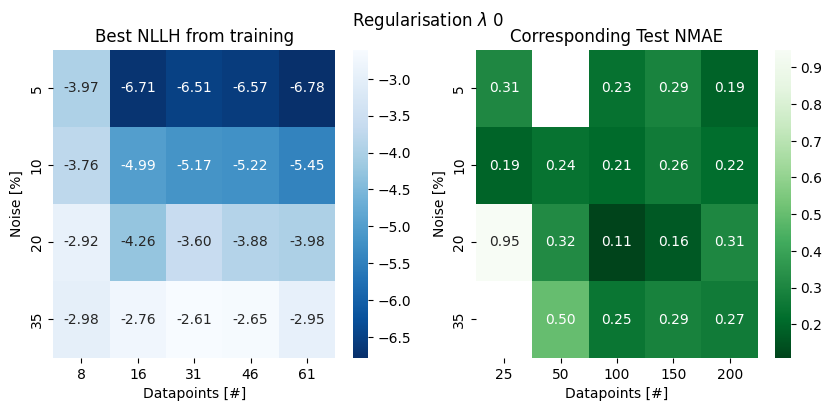

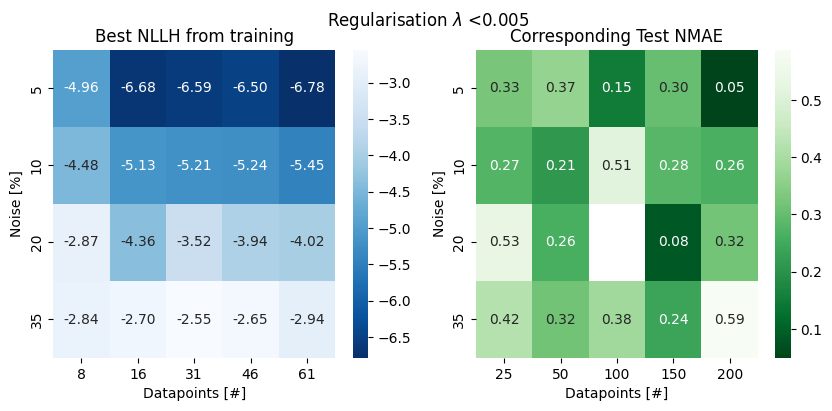

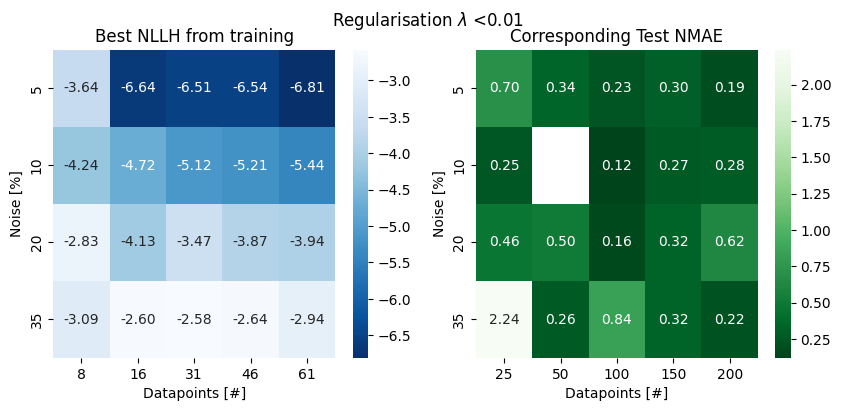

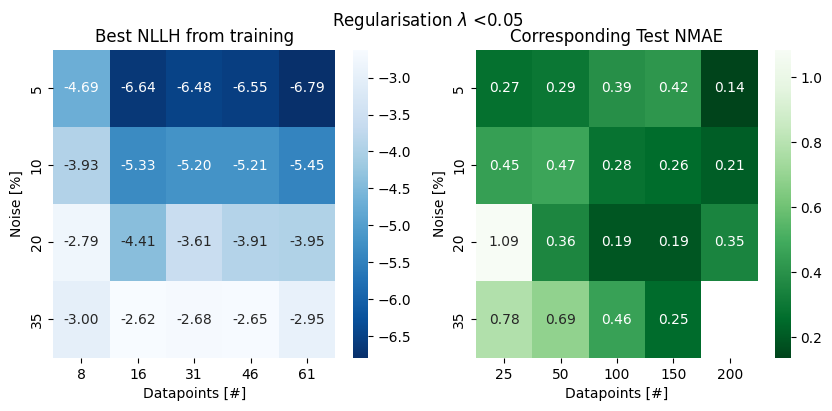

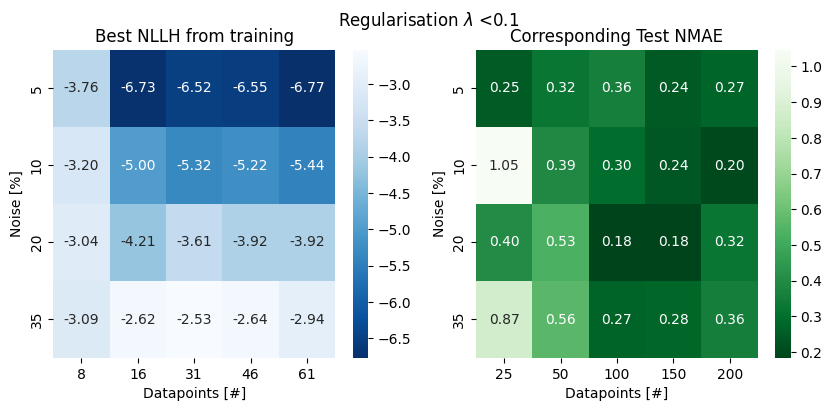

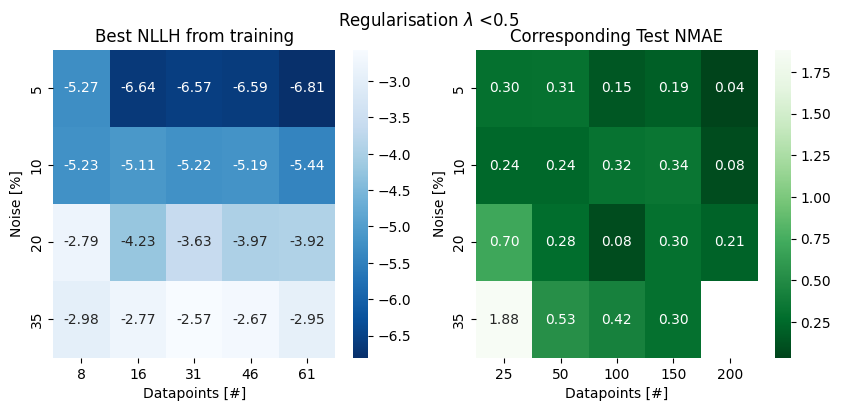

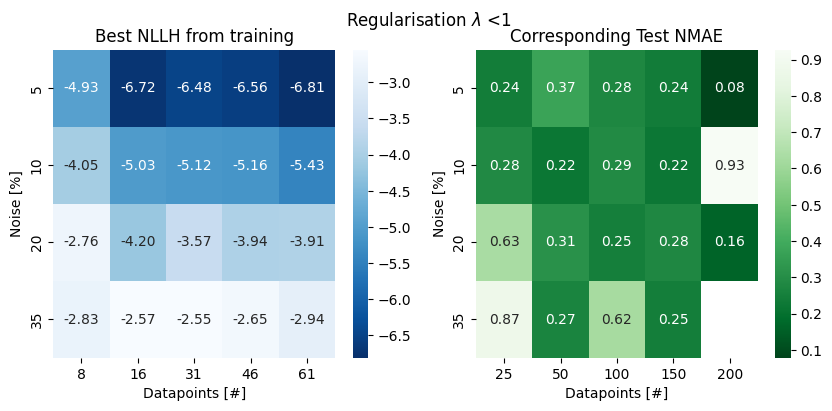

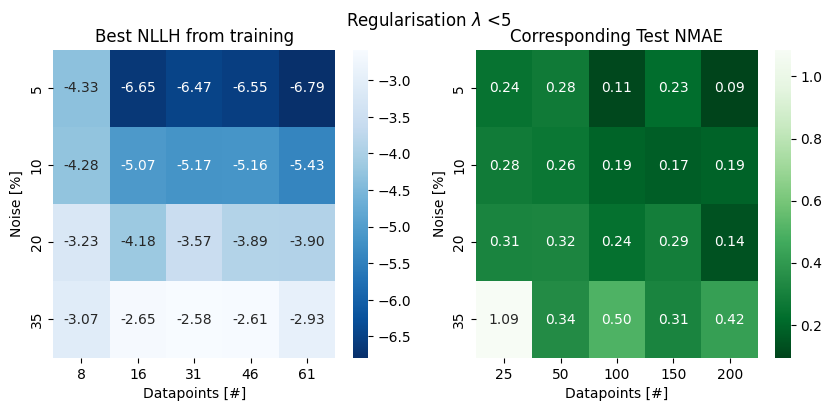

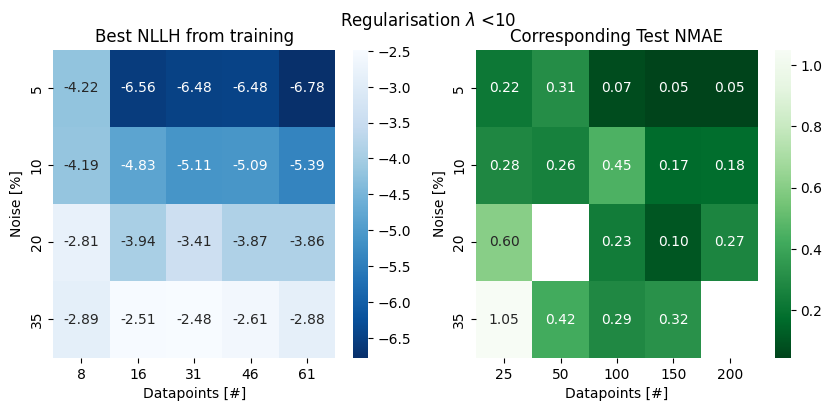

In [12]:
for bin in labels:
    # print(bin)
    # summary.query("regbin == @bin")

    best_ude_nrs = []
    for (noise, n_datapoints) in data_settings():
        best = summary.query(
            "regbin == @bin & (noise_level == @noise) & (sparsity == @n_datapoints)"
        ).sort_values(by=metric).iloc[0]["ude_nr"]
        best_ude_nrs.append(best)
    
    summary_of_best = summary.query("ude_nr in @best_ude_nrs")

    fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
    fig.suptitle(f"Regularisation $\lambda$ {bin}")
    # show likelihood
    sns.heatmap(
        summary_of_best.pivot(index="noise_level", columns="ndp", values=metric_norm),
        annot=True,
        fmt=".2f",
        cmap="Blues_r",
        ax=ax[0]
    )
    ax[0].set(xlabel="Datapoints [#]", ylabel="Noise [%]")
    ax[0].set_title("Best NLLH from training")
    # show NMSE on test data
    sns.heatmap(
        summary_of_best.pivot(index="noise_level", columns="sparsity", values="nmae_obs_test"),
        annot=True,
        fmt=".2f",
        cmap="Greens_r",
        ax=ax[1]
    )
    ax[1].set(xlabel="Datapoints [#]", ylabel="Noise [%]")
    ax[1].set_title("Corresponding Test NMAE")
    plt.show()

### Best likelihood/NMSE by regularisation

In [9]:
def normalise_data(data):
    return (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))

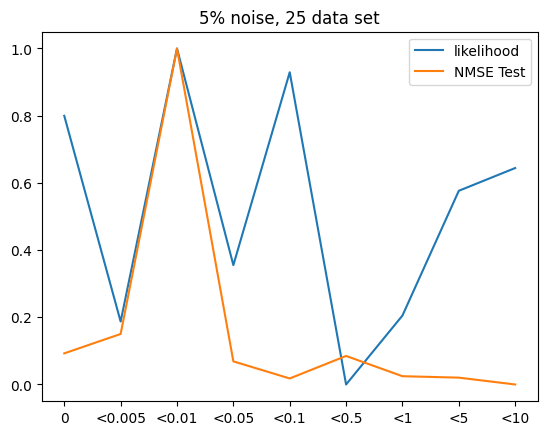

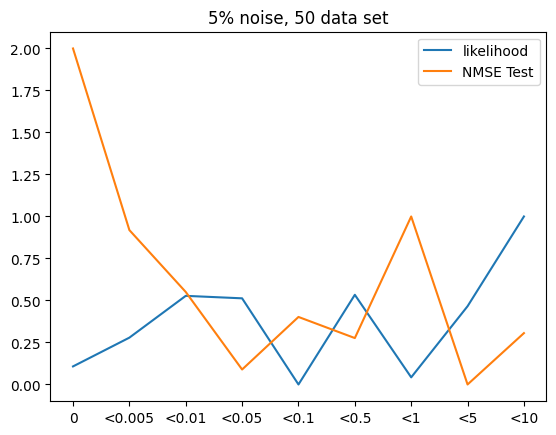

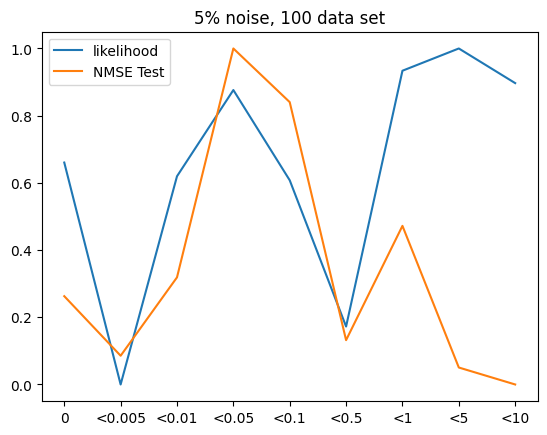

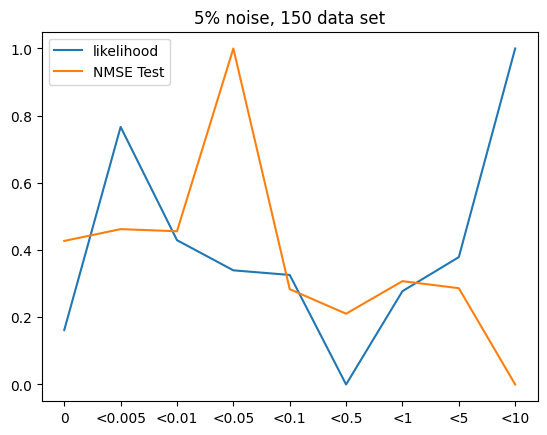

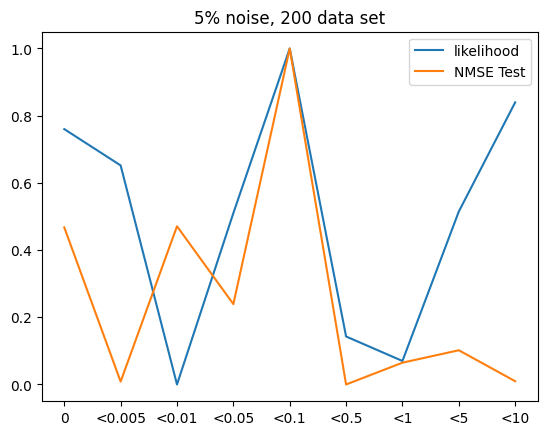

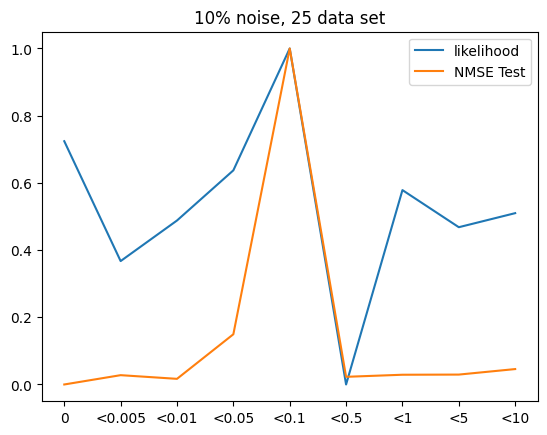

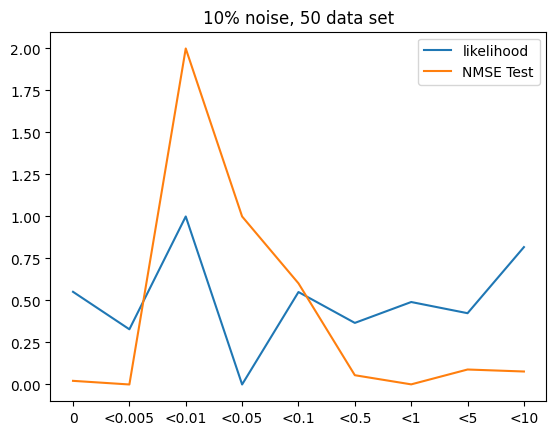

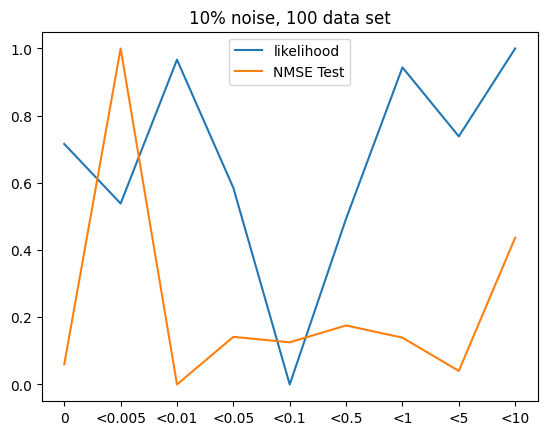

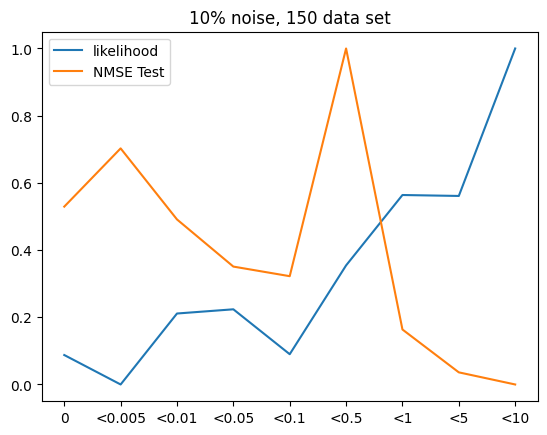

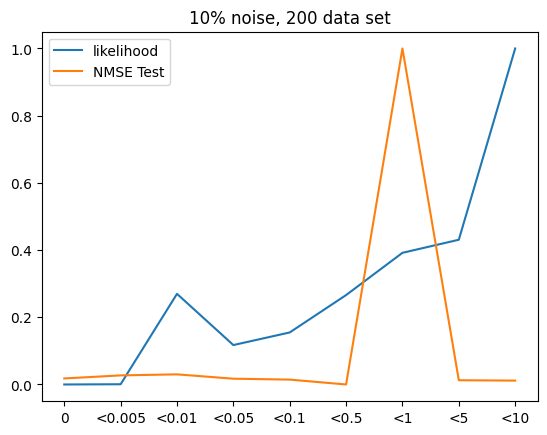

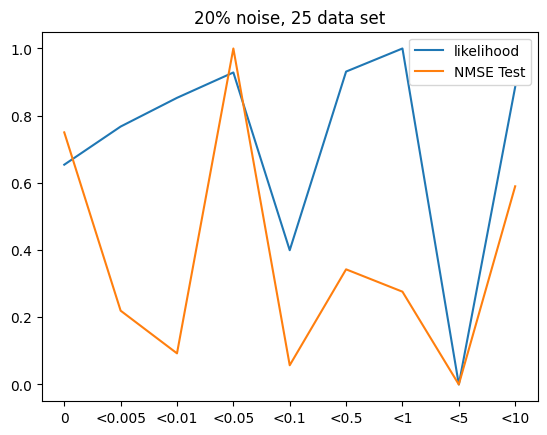

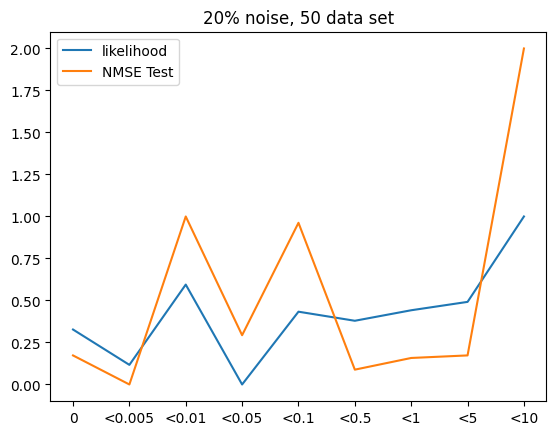

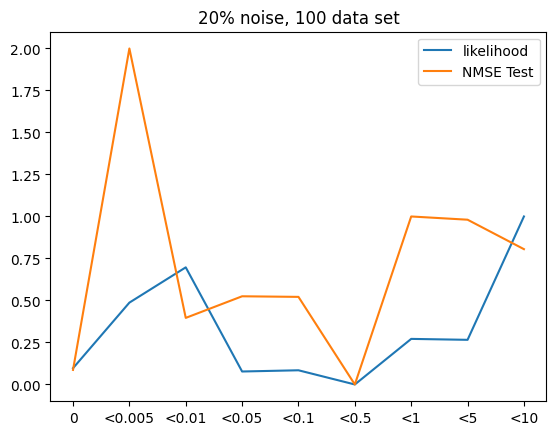

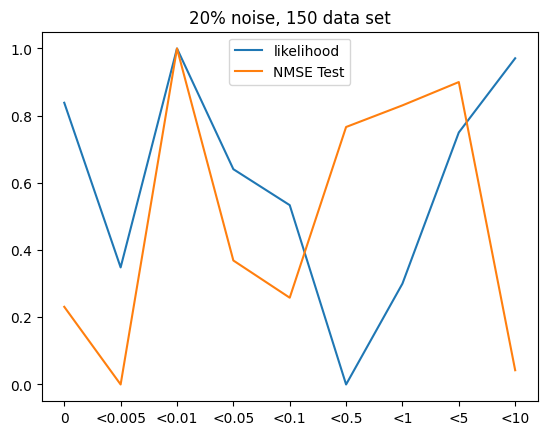

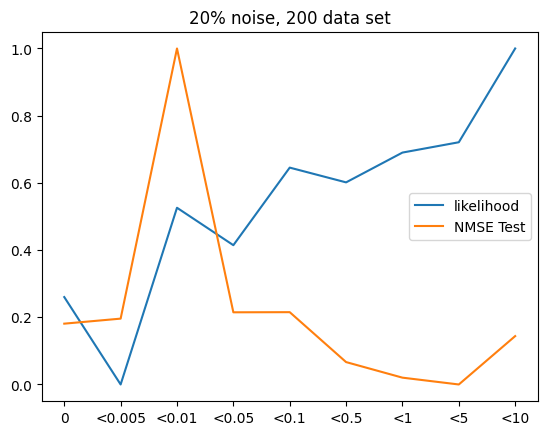

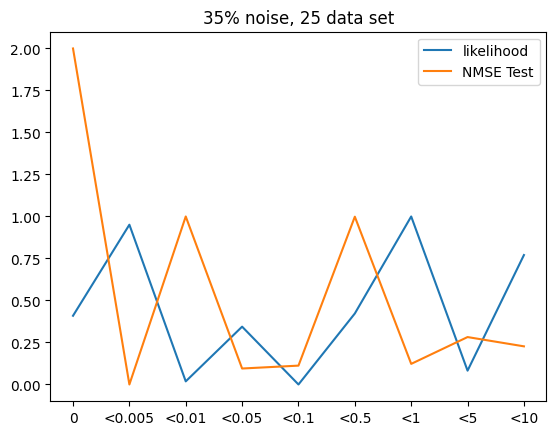

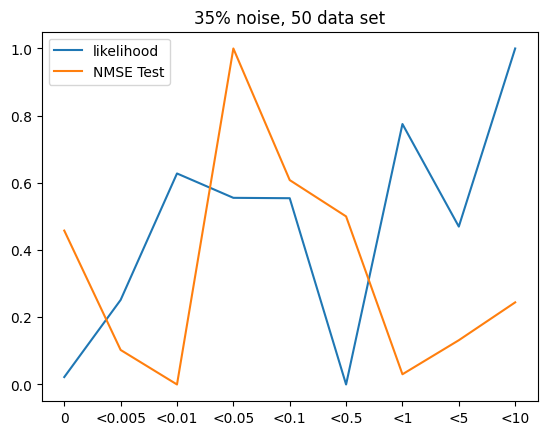

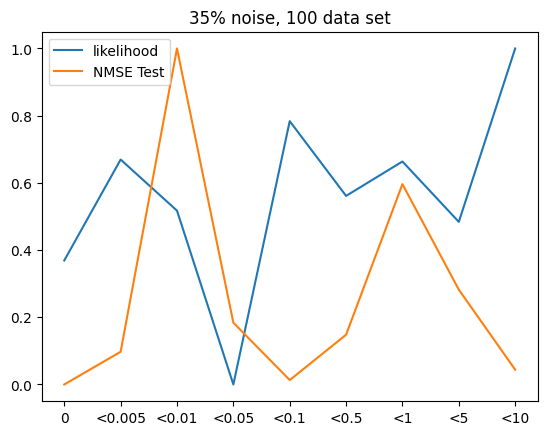

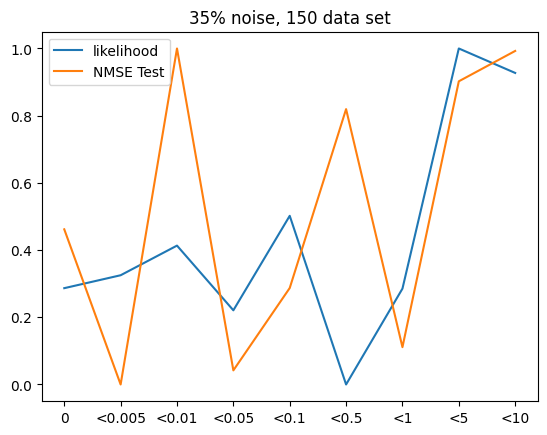

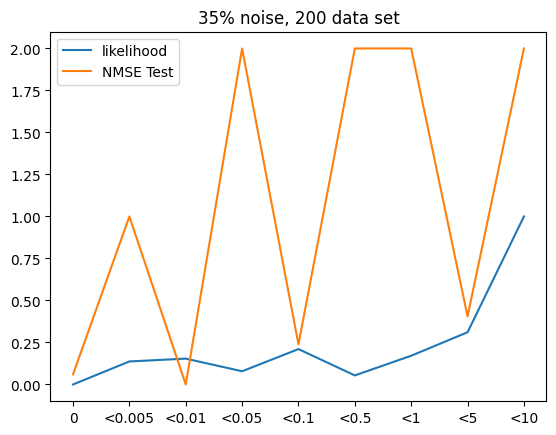

In [10]:
for (noise, n_datapoints) in data_settings():

    likelihood = []
    nmse_test = []
    for bin in labels:
        best = summary.query(
            "regbin == @bin & (noise_level == @noise) & (sparsity == @n_datapoints)"
        ).sort_values(by=metric).iloc[0]  # ["ude_nr"]
        likelihood.append(best[metric_norm])
        nmse_test.append(best["nmse_obs_test"])
    likelihood_normalised = normalise_data(likelihood)
    nmse_test_normalised = normalise_data(nmse_test)
    # replace NAN with 2
    nmse_test_normalised = [2 if np.isnan(i) else i for i in nmse_test_normalised]

    plt.plot(labels, likelihood_normalised, label="likelihood")
    plt.plot(labels, nmse_test_normalised, label="NMSE Test")
    plt.legend()
    plt.title(f"{noise}% noise, {n_datapoints} data set")
    plt.show()

### Heatmap: Regularisation effect by noise/sparsity

In [10]:
from itertools import product

In [11]:
bins = [-1, 1e-3, 1e-2, 1e-1, 1, 1e1]
labels = ["0", "<0.01", "<0.1", "<1", "<10"]

summary["1"] = 1
summary["regbin"] = pd.cut(summary['regularisation'], bins=bins, labels=labels)

In [12]:
best_ude_nrs = []
for (noise, reg_) in product(NOISE_PERCENTAGES, labels):
    best = summary.query(
        "noise_level == @noise & (regbin == @reg_)"
    ).sort_values(by=metric).iloc[0]["ude_nr"]
    best_ude_nrs.append(best)

summary_of_best = summary.query("ude_nr in @best_ude_nrs")

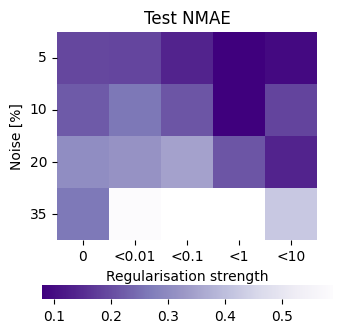

In [13]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))
ax = sns.heatmap(
    summary_of_best.pivot(index="noise_level", columns="regbin", values=metric_test),
    cmap="Purples_r",
    square=True,
    cbar_kws={"orientation": "horizontal"},
    ax=ax,
)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set(xlabel="Regularisation strength", ylabel="Noise [%]")
ax.set_title("Test NMAE")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
fig.tight_layout()
fp_output = dir_output / "heatmap_reg_noise_nmae.svg"
fig.savefig(fp_output)

In [14]:
success_count = summary.groupby(
    by=["noise_level", "regbin"]
)["success"].sum().reset_index().pivot(
    index="noise_level", columns="regbin", values="success"
)
attempts_count = summary.groupby(
    by=["noise_level", "regbin"]
)["1"].sum().reset_index().pivot(
    index="noise_level", columns="regbin", values="1"
)
succes_percentage = success_count / attempts_count * 100
succes_percentage.max().max()

/tmp/ipykernel_87208/4231126682.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_count = summary.groupby(
/tmp/ipykernel_87208/4231126682.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attempts_count = summary.groupby(


3.5616991221874685

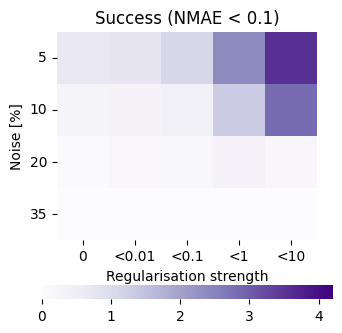

In [15]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.heatmap(
    succes_percentage,
    cmap="Purples",
    # annot=True,
    # fmt=".0f",
    square=True,
    cbar_kws={"orientation": "horizontal"},
    vmin=0, vmax=4.2,
    ax=ax,
)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set(xlabel="Regularisation strength", ylabel="Noise [%]")
ax.set_title("Success (NMAE < 0.1)")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
fig.tight_layout()
fp_output = dir_output / "heatmap_reg_noise_success.svg"
fig.savefig(fp_output)

/tmp/ipykernel_87208/3642593481.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_table = summary.groupby(["noise_level", "regbin"])["success"].sum().reset_index().pivot(index="noise_level", columns="regbin", values="success")


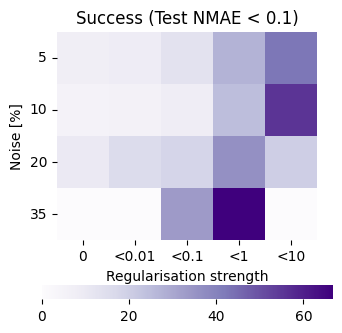

In [42]:
# Nina's approach

pivot_table = summary.groupby(["noise_level", "regbin"])["success"].sum().reset_index().pivot(index="noise_level", columns="regbin", values="success")

pivot_table = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.heatmap(
    pivot_table,
    cmap="Purples",
    square=True,
    cbar_kws={"orientation": "horizontal"},
    vmin=0,
    ax=ax,
)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set(xlabel="Regularisation strength", ylabel="Noise [%]")
ax.set_title("Success (Test NMAE < 0.1)")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
fig.tight_layout()
fp_output = dir_output / "heatmap_reg_noise_success_perrow.svg"
fig.savefig(fp_output)

In [192]:
best_ude_nrs = []
for (ndp, reg_) in product(DATASET_SIZES, labels):
    best = summary.query(
        "sparsity == @ndp & (regbin == @reg_)"
    ).sort_values(by=metric).iloc[0]["ude_nr"]
    best_ude_nrs.append(best)

summary_of_best = summary.query("ude_nr in @best_ude_nrs")

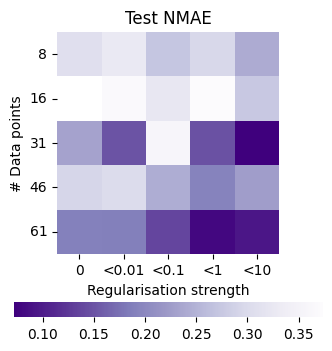

In [193]:
fig, ax = plt.subplots(figsize=(3.5, 3.7))
sns.heatmap(
    summary_of_best.pivot(index="ndp", columns="regbin", values=metric_test),
    cmap="Purples_r",
    square=True,
    cbar_kws={"orientation": "horizontal"},
    ax=ax,
)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set(xlabel="Regularisation strength", ylabel="# Data points")
ax.set_title("Test NMAE")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
fig.tight_layout()
fp_output = dir_output / "heatmap_reg_ndps_nmae.svg"
fig.savefig(fp_output)

In [194]:
success_count = summary.groupby(
    by=["ndp", "regbin"]
)["success"].sum().reset_index().pivot(
    index="ndp", columns="regbin", values="success"
)
attempts_count = summary.groupby(
    by=["ndp", "regbin"]
)["1"].sum().reset_index().pivot(
    index="ndp", columns="regbin", values="1"
)
success_percentage = success_count / attempts_count * 100
success_percentage.max().max()

/tmp/ipykernel_49993/2918170464.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_count = summary.groupby(
/tmp/ipykernel_49993/2918170464.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attempts_count = summary.groupby(


4.172821270310192

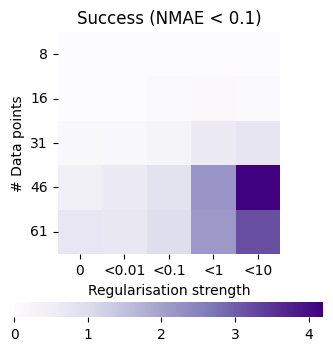

In [195]:
fig, ax = plt.subplots(figsize=(3.5, 3.7))
sns.heatmap(
    success_percentage,
    cmap="Purples",
    # annot=True,
    # fmt=".0f",
    square=True,
    cbar_kws={"orientation": "horizontal"},
    vmin=0, vmax=4.2,
    ax=ax,
)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set(xlabel="Regularisation strength", ylabel="# Data points")
ax.set_title("Success (NMAE < 0.1)")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
fig.tight_layout()
fp_output = dir_output / "heatmap_reg_ndp_success.svg"
fig.savefig(fp_output)

/tmp/ipykernel_87208/2963796362.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_table = summary.groupby(["ndp", "regbin"])["success"].sum().reset_index().pivot(index="ndp", columns="regbin", values="success")


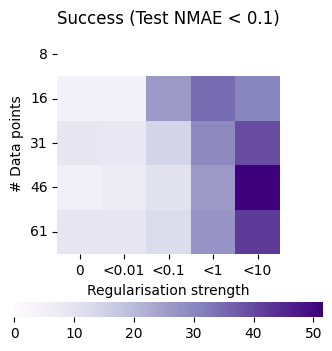

In [39]:
# Nina's approach

pivot_table = summary.groupby(["ndp", "regbin"])["success"].sum().reset_index().pivot(index="ndp", columns="regbin", values="success")

pivot_table = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(3.5, 3.7))
sns.heatmap(
    pivot_table,
    cmap="Purples",
    square=True,
    cbar_kws={"orientation": "horizontal"},
    vmin=0,
    ax=ax,
)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set(xlabel="Regularisation strength", ylabel="# Data points")
ax.set_title("Success (Test NMAE < 0.1)")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
fig.tight_layout()
fp_output = dir_output / "heatmap_reg_ndp_success_perrow.svg"
fig.savefig(fp_output)

## Qualitative Evaluation

In [53]:
df_osc = pd.read_csv("qualitative/oscillations.tsv", sep="\t")
df_freq = pd.read_csv("qualitative/frequency.tsv", sep="\t")
df_amp = pd.read_csv("qualitative/amplitude.tsv", sep="\t")
for dfi in [df_osc, df_freq, df_amp]:
    dfi["Best10"] = dfi[[str(i) for i in range(1, 11)]].sum(axis=1)
    dfi.rename(columns={"1": "Best"}, inplace=True)
    dfi["ndp"] = dfi["Sparsity"].map(sparsity_to_dps)
df_osc

,Noise,Sparsity,Best,2,3,4,5,6,7,8,9,10,Best10,ndp
0,5,25,0,1,0,0,0,0,1,0,0,0,2,8
1,5,50,1,1,1,0,1,1,1,1,1,1,9,16
2,5,100,1,1,1,1,1,1,1,0,1,1,9,31
3,5,150,1,1,1,1,1,0,1,1,1,1,9,46
4,5,200,1,1,1,1,1,1,1,1,1,1,10,61
5,10,25,0,0,0,0,0,1,0,0,0,1,2,8
6,10,50,0,1,1,1,1,1,1,1,1,1,9,16
7,10,100,0,1,1,1,1,1,1,1,1,1,9,31
8,10,150,0,1,1,0,0,0,1,0,1,0,4,46
9,10,200,1,1,1,1,1,1,1,1,1,1,10,61


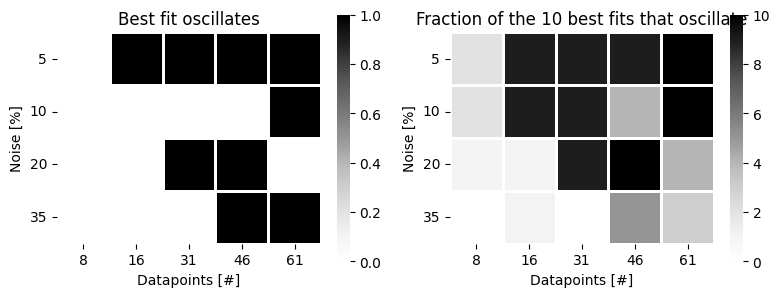

In [54]:
fig, ax = plt.subplots(figsize=(8, 3), ncols=2)
sns.heatmap(
    df_osc.pivot(index="Noise", columns="ndp", values="Best"),
    cmap="Greys",
    linewidths=2,
    # linecolor="grey"
    square=True,
    ax=ax[0],
)
ax[0].set_yticklabels(ax[0].get_yticklabels(), rotation=0)
ax[0].set(xlabel="Datapoints [#]", ylabel="Noise [%]")
ax[0].set_title("Best fit oscillates")

sns.heatmap(
    df_osc.pivot(index="Noise", columns="ndp", values="Best10"),
    cmap="Greys",
    linewidths=2,
    square=True,
    ax=ax[1],
    vmin=0, vmax=10,
)
ax[1].set_yticklabels(ax[1].get_yticklabels(), rotation=0)
ax[1].set(xlabel="Datapoints [#]", ylabel="Noise [%]")
ax[1].set_title("Fraction of the 10 best fits that oscillate")

fig.tight_layout()
fp_output = dir_output / "heatmap_oscillations.svg"
fig.savefig(fp_output)

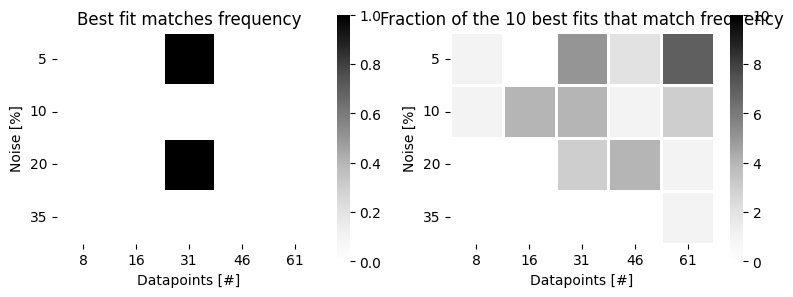

In [55]:
fig, ax = plt.subplots(figsize=(8, 3), ncols=2)
sns.heatmap(
    df_freq.pivot(index="Noise", columns="ndp", values="Best"),
    cmap="Greys",
    linewidths=2,
    # linecolor="grey"
    square=True,
    ax=ax[0],
)
ax[0].set_yticklabels(ax[0].get_yticklabels(), rotation=0)
ax[0].set(xlabel="Datapoints [#]", ylabel="Noise [%]")
ax[0].set_title("Best fit matches frequency")

sns.heatmap(
    df_freq.pivot(index="Noise", columns="ndp", values="Best10"),
    cmap="Greys",
    linewidths=2,
    square=True,
    ax=ax[1],
    vmin=0, vmax=10,
)
ax[1].set_yticklabels(ax[1].get_yticklabels(), rotation=0)
ax[1].set(xlabel="Datapoints [#]", ylabel="Noise [%]")
ax[1].set_title("Fraction of the 10 best fits that match frequency")

fig.tight_layout()
fp_output = dir_output / "heatmap_frequency.svg"
fig.savefig(fp_output)

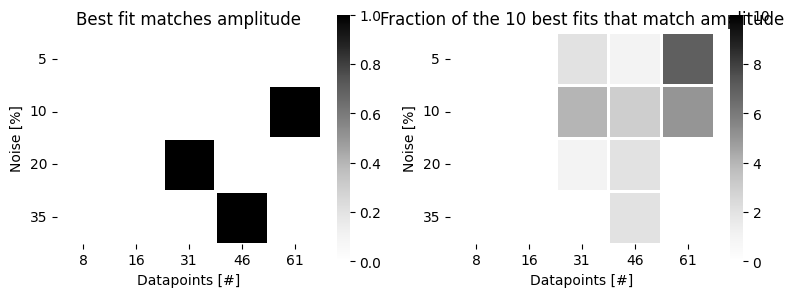

In [56]:
fig, ax = plt.subplots(figsize=(8, 3), ncols=2)
sns.heatmap(
    df_amp.pivot(index="Noise", columns="ndp", values="Best"),
    cmap="Greys",
    linewidths=2,
    # linecolor="grey"
    square=True,
    ax=ax[0],
)
ax[0].set_yticklabels(ax[0].get_yticklabels(), rotation=0)
ax[0].set(xlabel="Datapoints [#]", ylabel="Noise [%]")
ax[0].set_title("Best fit matches amplitude")

sns.heatmap(
    df_amp.pivot(index="Noise", columns="ndp", values="Best10"),
    cmap="Greys",
    linewidths=2,
    square=True,
    ax=ax[1],
    vmin=0, vmax=10,
)
ax[1].set_yticklabels(ax[1].get_yticklabels(), rotation=0)
ax[1].set(xlabel="Datapoints [#]", ylabel="Noise [%]")
ax[1].set_title("Fraction of the 10 best fits that match amplitude")

fig.tight_layout()
fp_output = dir_output / "heatmap_amplitude.svg"
fig.savefig(fp_output)